<a href="https://colab.research.google.com/github/Rodrigo-Filho/IA_AgroCareTech/blob/main/ML_AgroCareTech_id.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FUNCIONALIDADE DE IDENTIFICAÇÃO DE FACE DE BOVINOS E ATRIBUIÇÃO DE UM ID ÚNICO A CADA ANIMAL**



Importação de bibliotecas necessárias e configuração do diretório:

OBS: Estamos trabalhando com um dataset que possui duas raças bovinas (Gir e Jersey), pois são comum no território brasileiro

In [76]:
import os
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Diretório do dataset
dataset_dir = '/content/drive/MyDrive/Update bovines'

Função para Carregar e Pré-processar Imagens:

In [77]:
def load_and_preprocess_images(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, (224, 224))
                img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
                img_array = img_to_array(img_rgb) / 255.0
                images.append(img_array)
    return np.array(images)

data = load_and_preprocess_images(dataset_dir)


Preparação das Labels e Divisão dos Dados:

In [78]:
labels = np.array([filename.split('_')[0] for filename in os.listdir(dataset_dir) if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png")])
unique_labels, labels_indices = np.unique(labels, return_inverse=True)
labels_one_hot = to_categorical(labels_indices)

X_train, X_test, y_train, y_test = train_test_split(data, labels_one_hot, test_size=0.2, random_state=42)


Definição e Treinamento do Modelo:

In [79]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(unique_labels), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.5257 - loss: 3.8459 - val_accuracy: 0.6486 - val_loss: 1.0449
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.6308 - loss: 0.7746 - val_accuracy: 0.6486 - val_loss: 0.6210
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.6516 - loss: 0.6169 - val_accuracy: 0.6486 - val_loss: 0.6292
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.6673 - loss: 0.6187 - val_accuracy: 0.6937 - val_loss: 0.5618
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.7500 - loss: 0.5364 - val_accuracy: 0.7658 - val_loss: 0.5691
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.7922 - loss: 0.5256 - val_accuracy: 0.6577 - val_loss: 0.5714
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.7610 - loss: 0.4944 - val_accuracy: 0.8108 - val_loss: 0.4569
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.8429 - loss: 0.3686 - val_accuracy: 0.7117 - val_loss:

Data Augmentation para criar variações de img:

OBS: A utilização do Data Augmentation é por conta de termos apenas 1 img por bovino

In [80]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = datagen.random_transform(img_array)
    img_array /= 255.0
    return np.expand_dims(img_array, axis=0)

model.save('bovine_face_recognition_model.h5')


Criação e Salvamento do CSV com IDs:

In [81]:
df_ids = pd.DataFrame({
    'Image': [filename for filename in os.listdir(dataset_dir) if filename.endswith((".jpg", ".jpeg", ".png"))],
    'ID': list(range(1, len([filename for filename in os.listdir(dataset_dir) if filename.endswith((".jpg", ".jpeg", ".png"))]) + 1))
})
df_ids.to_csv('/content/bovine_face_ids.csv', index=False)
print("Arquivo CSV 'bovine_face_ids.csv' gerado com sucesso!")


Arquivo CSV 'bovine_face_ids.csv' gerado com sucesso!


Salvamento das Previsões em CSV:

In [82]:
model = load_model('/content/bovine_face_recognition_model.h5')
df_ids = pd.read_csv('/content/bovine_face_ids.csv')

def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

image_files = [f for f in os.listdir(dataset_dir) if f.endswith((".jpg", ".jpeg", ".png"))]
image_files.sort()

file_to_id = {row['Image']: row['ID'] for _, row in df_ids.iterrows()}
data = np.array([load_and_preprocess_image(os.path.join(dataset_dir, file)) for file in image_files])
data = np.vstack(data)
predictions = model.predict(data)
predicted_labels = np.argmax(predictions, axis=1)

df_predictions = pd.DataFrame({
    'Image': image_files,
    'Predicted ID': [file_to_id[file] for file in image_files]
})
df_predictions.to_csv('/content/bovine_face_predictions.csv', index=False)
print("Arquivo CSV 'bovine_face_predictions.csv' gerado com sucesso!")


18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 993ms/step
Arquivo CSV 'bovine_face_predictions.csv' gerado com sucesso!


Avaliação do Modelo:

In [83]:
y_true = [filename.split('_')[0] for filename in image_files]
unique_labels = np.unique(y_true)
predicted_labels_names = [unique_labels[label] for label in predicted_labels]
print(classification_report(y_true, predicted_labels_names))
print("Acurácia:", accuracy_score(y_true, predicted_labels_names))


              precision    recall  f1-score   support

         Gir       0.78      0.99      0.87       350
      Jersey       0.95      0.52      0.67       203

    accuracy                           0.81       553
   macro avg       0.87      0.75      0.77       553
weighted avg       0.84      0.81      0.80       553

Acurácia: 0.8137432188065099


Reconhecimento e Visualização de Imagem Específica:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Imagem: Gir_87.jpg
O ID do bovino reconhecido é: 384
O ID real do bovino é: 384


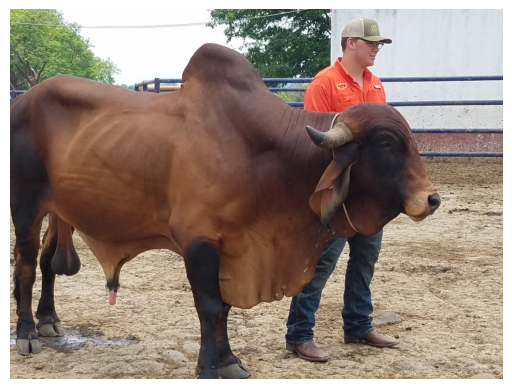

O ID reconhecido está correto.


In [84]:
def recognize_bovine(img_path):
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array)
    predicted_label_index = np.argmax(prediction, axis=1)[0]
    predicted_label = list(label_to_id.keys())[predicted_label_index]
    bovine_id = label_to_id.get(predicted_label, None)
    return bovine_id

def show_image(img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

specific_image_file = 'Gir_87.jpg'
specific_image_path = os.path.join(dataset_dir, specific_image_file)
real_id = path_to_id.get(specific_image_path, None)
predicted_id = recognize_bovine(specific_image_path)

print(f'Imagem: {specific_image_file}')
print(f'O ID do bovino reconhecido é: {predicted_id}')
print(f'O ID real do bovino é: {real_id}')

show_image(specific_image_path)

if predicted_id == real_id:
    print('O ID reconhecido está correto.')
else:
    print('O ID reconhecido está incorreto.')
